In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train[:500].astype('float32') / 255.0
x_test = x_test[:100].astype('float32') / 255.0

# Convert to grayscale
x_train_gray = tf.image.rgb_to_grayscale(x_train)
x_test_gray = tf.image.rgb_to_grayscale(x_test)

# Load VGG16 (include_top=True for embedding, input shape must be (224,224,3))
vgg16 = VGG16(weights='imagenet', include_top=True)
vgg16.trainable = False


In [7]:
def create_vgg_embedding(gray_imgs):
    # Convert grayscale to RGB and resize to 224x224
    rgb_imgs = [gray2rgb(resize(img.squeeze(), (224, 224))) for img in gray_imgs]
    rgb_imgs = np.array(rgb_imgs)
    rgb_imgs = preprocess_input(rgb_imgs)
    embeddings = vgg16.predict(rgb_imgs)
    return embeddings


In [8]:
# Colorization model with VGG fusion
def build_fusion_colorization_model(embedding_dim=1000):
    input_img = layers.Input(shape=(32, 32, 1), name='gray_input')
    emd_input = layers.Input(shape=(embedding_dim,), name='vgg_embedding')

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(input_img)  # (16x16x64)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)         # (8x8x128)

    # Fusion with VGG embedding
    fusion = layers.RepeatVector(8 * 8)(emd_input)
    fusion = layers.Reshape((8, 8, embedding_dim))(fusion)
    x = layers.Concatenate()([x, fusion])
    x = layers.Conv2D(128, (1, 1), activation='relu', padding='same')(x)  # Reduce channel dimension

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)  # (16x16)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # (32x32)
    output_img = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs=[input_img, emd_input], outputs=output_img)
    return model

In [9]:
model = build_fusion_colorization_model()
model.compile(optimizer='adam', loss='mse')


In [10]:
# Create training set embeddings
x_train_gray_np = x_train_gray.numpy()
train_embeddings = create_vgg_embedding(x_train_gray_np)

# Train
model.fit(
    [x_train_gray_np, train_embeddings],
    x_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1
)



16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 885ms/step - loss: 0.0607 - val_loss: 0.0591
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0566 - val_loss: 0.0504
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0453 - val_loss: 0.0343
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0293 - val_loss: 0.0250
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0216 - val_loss: 0.0222
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0205 - val_loss: 0.0229
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0201 - val_loss: 0.0200
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0180 - val_loss: 0.0194
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0171 - val_loss: 0.0186
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0169 - val_loss: 0.0184


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0162
Test MSE: 0.0160
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


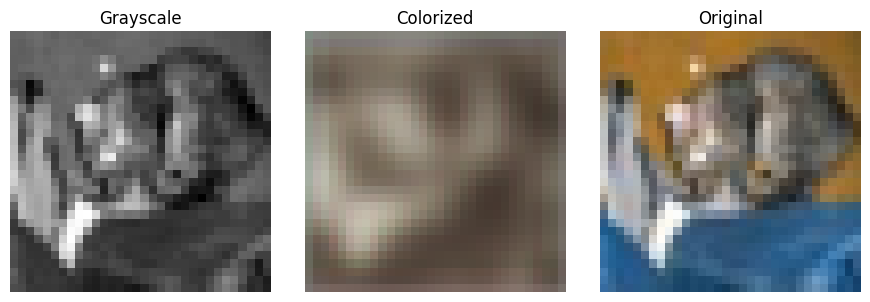

In [11]:
# Evaluate on test set
x_test_gray_np = x_test_gray.numpy()
test_embeddings = create_vgg_embedding(x_test_gray_np)
loss = model.evaluate([x_test_gray_np, test_embeddings], x_test)
print(f"Test MSE: {loss:.4f}")

# Predict and visualize
predicted = model.predict([x_test_gray_np, test_embeddings])

# Show sample
index = 0
gray_img = x_test_gray_np[index].reshape(32, 32)
colorized_img = predicted[index]
original_img = x_test[index]

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(colorized_img)
plt.title("Colorized")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(original_img)
plt.title("Original")
plt.axis("off")
plt.tight_layout()
plt.show()